In [1]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import Normalizer, StandardScaler

import pandas as pd
import numpy as np

In [2]:
df_train = pd.read_csv("train.csv", index_col=0)

#### Функции выполняющие модификацию данных

In [3]:
from sklearn.decomposition import PCA

#Применяет PCA к параметрам из params на выходе возвращает dataframe с новым параметром param_name и без параметров params
def uniteParams(df, params, param_name):
    pca = PCA(n_components=1)
    kulin = df[params]

    pca.fit(kulin)
    kulin = pca.transform(kulin)
    df[param_name] = kulin
    df.drop(params, axis=1)

    return df

def fillNaMedian(df, params):
    for i in params:
        df[i] = df[i].fillna(df[i].median())
    return df

def removeDropouts(df, params):
    def application(x, minE, maxE):
            if x < minE:
                return minE
            elif x > maxE:
                return maxE
            else:
                x

    for i in params:
        min = df[i].quantile(0.99)
        max = df[i].quantile(0.01)
        
        df[i] = df[i].apply(lambda x: application(x, min, max))

    return df

def one_hot_encode_feature(dataframe, features):
    encoded_df = dataframe
    for feature_name in features:
        encoded_df = pd.get_dummies(encoded_df, columns=[feature_name], prefix=[feature_name])
    return encoded_df



In [4]:
from sklearn.preprocessing import RobustScaler

def normalize_dataframe(df):
    # Select only numerical columns
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    
    # Replace infinite or too large values with a large finite value
    df.replace([np.inf], 1e9, inplace=True)
    df.replace([-np.inf], -1e9, inplace=True)
    
    # Apply normalization to each column
    scaler = RobustScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    
    return df

#### Converter

Converter, который удобно применить для тренировочных и для тестовых данных. Использует фукнции написанные в предыдущих двух ячейках, а также создает новый коэффициенты

In [5]:
def convertFeatures(df):
    
    # dropouts = ["income"]
    # df = fillNaMedian(df, dropouts)

    cats = ["loan_purpose", "applicant_sex", "co_applicant_sex", "preapproval", "property_type", "purchaser_type", "msamd"]
    df = one_hot_encode_feature(df, cats)

    df = df.drop(["applicant_race_4", "applicant_race_5", "co_applicant_race_4", "co_applicant_race_5"], axis=1)

    applicant_races = ["applicant_race_1", "applicant_race_2", "applicant_race_3"]
    df = fillNaMedian(df, applicant_races)
    df = uniteParams(df, applicant_races, "applicant_race")

    co_applicant_races = ["co_applicant_race_1", "co_applicant_race_2", "co_applicant_race_3"]
    df = fillNaMedian(df, co_applicant_races)
    df = uniteParams(df, co_applicant_races, "co_applicant_race")


    df["coeff"] = df["loan_amount"]/df["hud_median_family_income"]
    df["coeff2"] = df["income"]/df["loan_amount"]

    df = normalize_dataframe(df)

    return df

In [6]:
X=df_train.drop(["target"], axis=1)
y=df_train["target"]

In [7]:
X = convertFeatures(X)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)

In [9]:
model = LGBMClassifier(
    verbosity=-1, 
    random_state=42,
    learning_rate=0.1,
    min_child_samples=20,
    max_depth=50, 
    n_estimators=1500,
    reg_alpha=1
)
model.fit(X_train, y_train)

LGBMClassifier(max_depth=50, n_estimators=1500, random_state=42, reg_alpha=1,
               verbosity=-1)

0.9257865868222703

In [299]:
y_pred = model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.9258268386512677

### CV

В свое время помогла сильно повысить производительность модели

In [ ]:
#Cross validation

from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

param_grid = {
    'max_depth': [30, 70, 100],
    'n_estimators': [200, 400, 600],
    'learning_rate': [0.05, 0.1, 0.2],
    'min_child_samples': [10, 20, 30],
    'reg_alpha': [0.1, 0.5, 1.0]
}

lgbm = LGBMClassifier(verbosity=-1, random_state=42)
grid_search = GridSearchCV(lgbm, param_grid, scoring='roc_auc', cv=3)
grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best ROC-AUC score: ", grid_search.best_score_)

### График важности фич

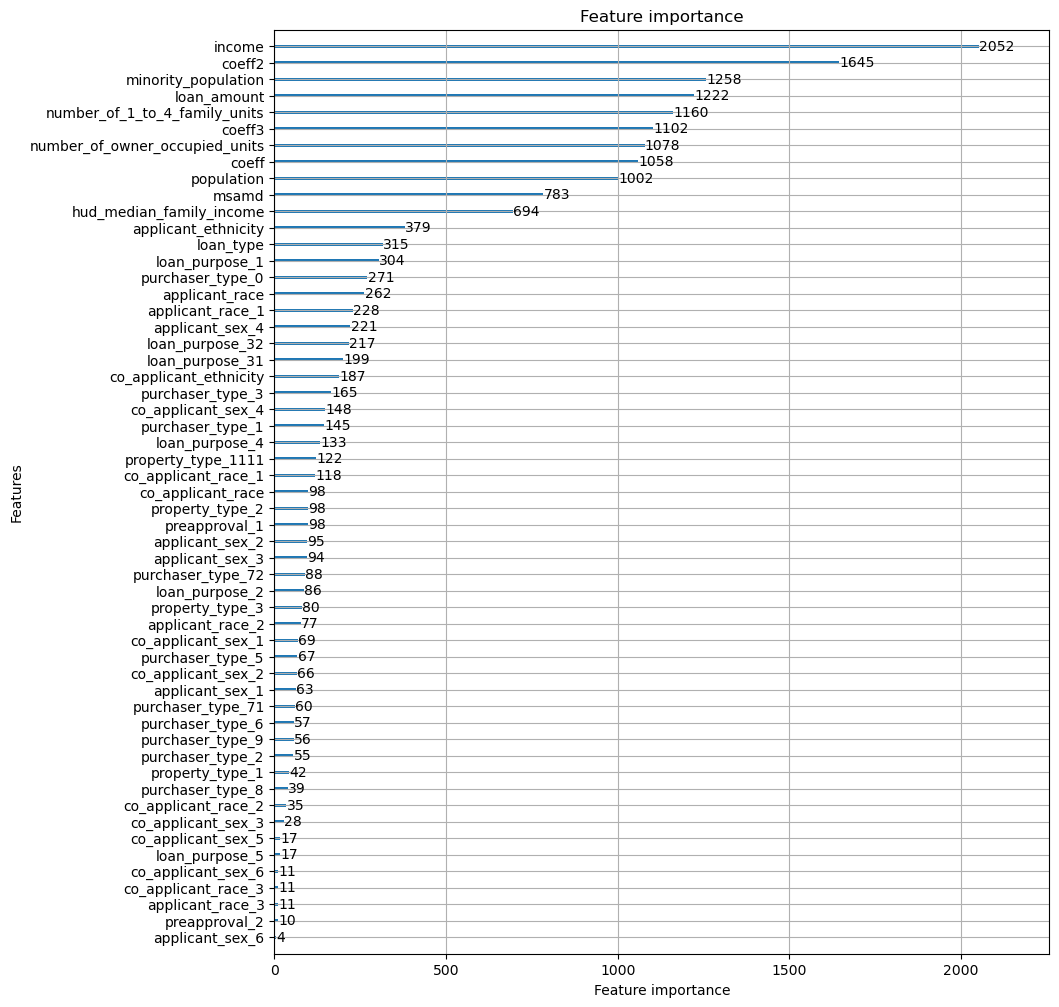

In [254]:
import lightgbm as lgb
import matplotlib.pyplot as plt

# Assuming your model is named 'model'
lgb.plot_importance(model, figsize=(10, 12))
plt.show()

### Подготовка отправки

In [269]:
X_test=pd.read_csv("test.csv", index_col=0)
X_test["income"].quantile(0.9999999)


X_test = convertFeatures(X_test)


In [270]:
test_score = model.predict_proba(X_test)[:, 1]
X_test["target"] = test_score
X_test.target.to_csv('submission.csv')
X_test["target"]

0         0.247523
1         0.323512
2         0.995885
3         0.000062
4         0.907765
            ...   
276898    0.000298
276899    0.230738
276900    0.999931
276901    0.995319
276902    0.083205
Name: target, Length: 276903, dtype: float64